<a href="https://colab.research.google.com/github/supertime1/dlaicourse/blob/master/Tensorflow_Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train Your Own Model and Serve It With TensorFlow Serving

In this notebook, you will train a neural network to classify images of handwritten digits from the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. You will then save the trained model, and serve it using [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).

**Warning: This notebook is designed to be run in a Google Colab only**.  It installs packages on the system and requires root access. If you want to run it in a local Jupyter notebook, please proceed with caution.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%204%20-%20TensorFlow%20Serving/Week%201/Exercises/TFServing_Week1_Exercise.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%204%20-%20TensorFlow%20Serving/Week%201/Exercises/TFServing_Week1_Exercise.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

## Setup

In [0]:
try:
    %tensorflow_version 2.x
except:
    pass

In [0]:
import os
import json
import tempfile
import requests
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.1.0


## Import the MNIST Dataset

The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains 70,000 grayscale images of the digits 0 through 9. The images show individual digits at a low resolution (28 by 28 pixels). 

Even though these are really images, we will load them as NumPy arrays and not as binary image objects.

In [0]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [0]:
# EXERCISE: Scale the values of the arrays below to be between 0.0 and 1.0.
train_images = train_images/255.0 # YOUR CODE HERE
test_images = test_images/255.0 # YOUR CODE HERE

In the cell below use the `.reshape` method to resize the arrays to the following sizes:

```python
train_images.shape: (60000, 28, 28, 1)
test_images.shape: (10000, 28, 28, 1)
```

In [0]:
# EXERCISE: Reshape the arrays below.
train_images = np.expand_dims(np.array(train_images), axis=3)# YOUR CODE HERE
test_images = np.expand_dims(np.array(test_images), axis=3)# YOUR CODE HERE

In [0]:
print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


## Look at a Sample Image

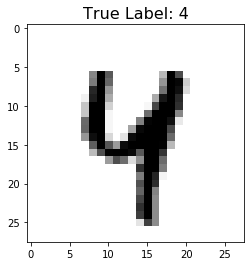

In [0]:
idx = 42

plt.imshow(test_images[idx].reshape(28,28), cmap=plt.cm.binary)
plt.title('True Label: {}'.format(test_labels[idx]), fontdict={'size': 16})
plt.show()

## Build a Model

In the cell below build a `tf.keras.Sequential` model that can be used to classify the images of the MNIST dataset. Feel free to use the simplest possible CNN. Make sure your model has the correct `input_shape` and the correct number of output units.

In [0]:
# EXERCISE: Create a model.
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(8,(1,1),strides=(1,1),activation='relu',input_shape=(28,28,1)),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPooling2D(pool_size=(1,2), strides=(1,2)),
                             tf.keras.layers.Dropout(0.2),
                             
                             tf.keras.layers.Conv2D(16,(1,3),strides=(1,1),activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPooling2D(pool_size=(1,2),strides=(1,2)),
                             tf.keras.layers.Dropout(0.2),

                             tf.keras.layers.Conv2D(32, (1, 3), strides=(1, 1),activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPooling2D(pool_size=(1, 2),strides=(1, 2)),
                             tf.keras.layers.Dropout(0.2),

                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(10, activation='softmax')
])
                             # YOUR CODE HERE

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 8)         16        
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 8)         32        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 14, 8)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 14, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 12, 16)        400       
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 12, 16)        64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 6, 16)        

## Train the Model

In the cell below configure your model for training using the `adam` optimizer, `sparse_categorical_crossentropy` as the loss, and `accuracy` for your metrics. Then train the model for the given number of epochs, using the `train_images` array.

In [0]:
# EXERCISE: Configure the model for training.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# YOUR CODE HERE)

epochs = 5


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
#split training to train and validation
train_images, validation_images, train_labels, validation_labels = train_test_split(train_images,train_labels, 
                                                                                    test_size=0.2, 
                                                                                    random_state=42)
# EXERCISE: Train the model.
history = model.fit(ImageDataGenerator().flow(train_images,train_labels,batch_size=32),
                    steps_per_epoch=len(train_images)/32,
                    epochs=epochs,
                    verbose=1,
                    validation_data=ImageDataGenerator().flow(validation_images,validation_labels,batch_size=32),
                    validation_steps=len(validation_images)/32)
    # YOUR CODE HERE)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1500.0 steps, validate for 375.0 steps
Epoch 1/5
1500/1500 [==============================] - 10s 7ms/step - loss: 0.3445 - accuracy: 0.8938 - val_loss: 0.1566 - val_accuracy: 0.9517
Epoch 2/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1929 - accuracy: 0.9401 - val_loss: 0.1298 - val_accuracy: 0.9578
Epoch 3/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1621 - accuracy: 0.9501 - val_loss: 0.1268 - val_accuracy: 0.9600
Epoch 4/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1496 - accuracy: 0.9534 - val_loss: 0.0909 - val_accuracy: 0.9726
Epoch 5/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1382 - accuracy: 0.9563 - val_loss: 0.0970 - val_accuracy: 0.9712


## Evaluate the Model

In [0]:
# EXERCISE: Evaluate the model on the test images.
results_eval = model.evaluate(test_images, test_labels, batch_size = 128)# YOUR CODE HERE

for metric, value in zip(model.metrics_names, results_eval):
    print(metric + ': {:.3}'.format(value))

10000/10000 [==============================] - 0s 38us/sample - loss: 0.0856 - accuracy: 0.9737
loss: 0.0856
accuracy: 0.974


## Save the Model

In [0]:
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)
print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}


Already saved a model, cleaning up

INFO:tensorflow:Assets written to: /tmp/1/assets

export_path = /tmp/1
total 480
drwxr-xr-x 2 root root   4096 Feb 24 02:37 assets
-rw-r--r-- 1 root root 480725 Feb 24 02:37 saved_model.pb
drwxr-xr-x 2 root root   4096 Feb 24 02:37 variables


## Examine Your Saved Model

In [0]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_3_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_conv2d_3_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_3'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Function Name:

## Add TensorFlow Serving Distribution URI as a Package Source

In [0]:
# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   143k      0 --:--:-- --:--:-- --:--:--  143k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InR

## Install TensorFlow Serving

In [0]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.1.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 107 not upgraded.


## Run the TensorFlow Model Server

You will now launch the TensorFlow model server with a bash script. In the cell below use the following parameters when running the TensorFlow model server:

* `rest_api_port`: Use port `8501` for your requests.


* `model_name`: Use `digits_model` as your model name. 


* `model_base_path`: Use the environment variable `MODEL_DIR` defined below as the base path to the saved model.

In [0]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [0]:
# EXERCISE: Fill in the missing code below.
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=digits_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 8 in a separate thread.


In [0]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 223] NET_LOG: Couldn't bind to port 8501
[evhttp_server.cc : 63] NET_LOG: Server has not been terminated. Force termination now.
[evhttp_server.cc : 258] NET_LOG: Server is not running ...
2020-02-24 02:41:41.620448: E tensorflow_serving/model_servers/server.cc:380] Failed to start HTTP Server at localhost:8501


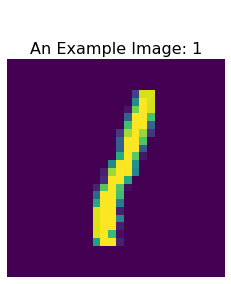

In [0]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(test_labels[rando]))

## Create JSON Object with Test Images

In the cell below construct a JSON object and use the first three images of the testing set (`test_images`) as your data.

In [0]:
# EXERCISE: Create JSON Object
data = json.dumps({'signature_name': 'serving_default', 'instances': test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))
# YOUR CODE HERE

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


## Make Inference Request

In the cell below, send a predict request as a POST to the server's REST endpoint, and pass it your test data. You should ask the server to give you the latest version of your model.

In [0]:
# EXERCISE: Fill in the code below
!pip install -q requests

import requests
headers = {'content-type': "application/json"}# YOUR CODE HERE
json_response = requests.post('http://localhost:8501/v1/models/digits_model:predict', data=data, headers=headers)# YOUR CODE HERE
    
predictions = json.loads(json_response.text)['predictions']

## Plot Predictions

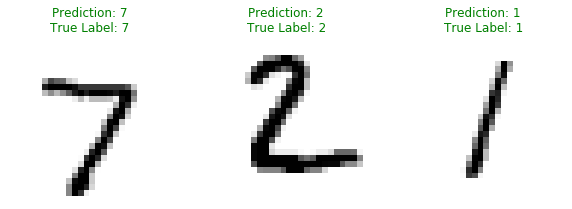

In [0]:
plt.figure(figsize=(10,15))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(test_images[i].reshape(28,28), cmap = plt.cm.binary)
    plt.axis('off')
    color = 'green' if np.argmax(predictions[i]) == test_labels[i] else 'red'
    plt.title('Prediction: {}\nTrue Label: {}'.format(np.argmax(predictions[i]), test_labels[i]), color=color)
    
plt.show()